Author: Jieyu Lian

Date: 11/04/2025

Description: This script performs the initial data preprocessing for the fracture detection project. It reads individual medical images in PNG format and converts them into tensor format, which is required for training neural networks. The script also ensures consistent image sizing and normalization to prepare the data for input into a deep learning model.



In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Adjust the path to your shared folder
fracAtlas = "/content/drive/MyDrive/FracAtlas"

# Subfolders
image_folder = f"{fracAtlas}/images/all"
annotation_folder = f"{fracAtlas}/Annotations/YOLO"
csv_path = f"{fracAtlas}/dataset.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import pandas as pd
import torch
from PIL import Image, ImageFile
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True

fracAtlas = "/content/drive/MyDrive/fracAtlas/FracAtlas"
all_folder = os.path.join(fracAtlas, "images", "all")
ann_yolo_folder = os.path.join(fracAtlas, "Annotations", "YOLO")

df = pd.read_csv(os.path.join(fracAtlas, "dataset.csv"))
df = df.rename(columns={"fractured": "label"})


In [15]:
# Custom PyTorch Dataset for Faster R-CNN training
class FracRCNNDataset(Dataset):
    def __init__(self, dataframe, image_folder, annotation_folder, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
       # Get image filename and load it
        image_name = self.df.loc[idx, "image_id"]
        image_path = os.path.join(self.image_folder, image_name)
        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        # Load YOLO-style bounding boxes
        boxes = load_yolo_annotations(image_name, self.annotation_folder)

        # Skip images without bounding boxes
        if len(boxes) == 0:
            return self.__getitem__((idx + 1) % len(self))

        # Convert YOLO format [x_center, y_center, w, h] → [xmin, ymin, xmax, ymax]
        converted_boxes = []
        for box in boxes:
            x_c, y_c, w, h = box
            xmin = (x_c - w/2) * width
            ymin = (y_c - h/2) * height
            xmax = (x_c + w/2) * width
            ymax = (y_c + h/2) * height
            converted_boxes.append([xmin, ymin, xmax, ymax])


        # Convert boxes and labels to PyTorch tensors
        boxes_tensor = torch.tensor(converted_boxes, dtype=torch.float32)
        labels_tensor = torch.ones((len(boxes_tensor),), dtype=torch.int64)

        target = {
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "image_id": torch.tensor([idx])
        }

        # Apply image transform (resize, tensor, etc.)
        if self.transform:
            image = self.transform(image)

        return image, target

# Read YOLO annotation file and return list of bounding boxes
def load_yolo_annotations(image_name, yolo_folder):
    path = os.path.join(yolo_folder, image_name.replace(".jpg", ".txt"))
    boxes = []
    if os.path.exists(path) and os.path.getsize(path) > 0:
        with open(path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                box = list(map(float, parts[1:]))
                boxes.append(box)
    return boxes

# Required for handling batches with variable-length targets (like multiple boxes)
def collate_fn(batch):
    return tuple(zip(*batch))

# Define image preprocessing steps
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])


In [16]:
#Train/test split and Dataloaders
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=1)

train_dataset = FracRCNNDataset(df_train, all_folder, ann_yolo_folder, transform)
test_dataset = FracRCNNDataset(df_test, all_folder, ann_yolo_folder, transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)


In [17]:
#Model initialization and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load pretrained Faster R-CNN backbone (ResNet50 + FPN)
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

# Replace classification head: original COCO head → fracture (1) + background (1)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.to(device)

# Set up SGD optimizer (standard settings)
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.005, momentum=0.9, weight_decay=0.0005)


In [18]:
model.train()
images, targets = next(iter(train_loader))
images = [img.to(device) for img in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

loss_dict = model(images, targets)
loss = sum(loss for loss in loss_dict.values())
print("One batch loss:", loss.item())


One batch loss: 33.134056091308594


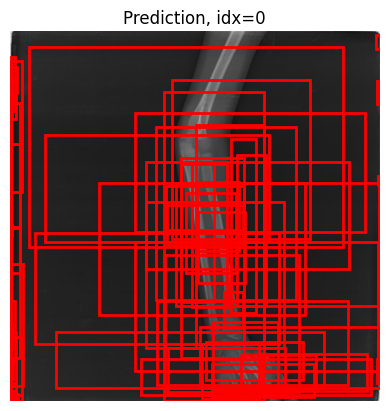

In [19]:
def predict_and_plot(model, dataset, idx, threshold=0.5):
    model.eval()
    image, target = dataset[idx]
    image = image.to(device)

    with torch.no_grad():
        prediction = model([image])[0]

    # Convert image to NumPy format for plotting
    image = image.cpu().permute(1, 2, 0).numpy()

    plt.imshow(image)
    plt.title(f"Prediction (idx={idx})")

    for box, score in zip(prediction["boxes"], prediction["scores"]):
        if score > threshold:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                              edgecolor='red', facecolor='none', linewidth=2))
    plt.title(f"Prediction, idx={idx}")
    plt.axis('off')
    plt.show()

# Example usage (visualize prediction on test image 0)
predict_and_plot(model, test_dataset, idx=0)
